In [1]:
!pip install torch torchvision torchaudio transformers librosa scikit-learn tqdm

In [3]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model, BertModel

class MultimodalFusionNet(nn.Module):
    def __init__(self, audio_model_name="facebook/wav2vec2-base-960h", text_model_name="bert-base-uncased", hidden_dim=512, num_classes=2):
        super().__init__()
        self.audio_model = Wav2Vec2Model.from_pretrained(audio_model_name)
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.fusion = nn.Sequential(
            nn.Linear(self.audio_model.config.hidden_size + self.text_model.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, audio_input, audio_mask, text_input, text_mask):
        audio_feat = self.audio_model(audio_input, attention_mask=audio_mask).last_hidden_state.mean(dim=1)
        text_feat = self.text_model(input_ids=text_input, attention_mask=text_mask).last_hidden_state[:,0,:]
        fused = torch.cat([audio_feat, text_feat], dim=1)
        logits = self.fusion(fused)
        return logits

*Custom Dataset and Dataloader*

In [4]:
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, BertTokenizer
import librosa

class MultimodalDataset(Dataset):
    def __init__(self, dataframe, wav2vec_processor, bert_tokenizer, max_length=128):
        self.data = dataframe
        self.wav2vec_processor = wav2vec_processor
        self.bert_tokenizer = bert_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path = self.data.iloc[idx]['audio_path']
        text_path = self.data.iloc[idx]['transcript_path']
        label = int(self.data.iloc[idx]['label'])

        # Audio
        audio, sr = librosa.load(audio_path, sr=16000)
        audio_inputs = self.wav2vec_processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        audio_input = audio_inputs.input_values[0]
        audio_mask = audio_inputs.attention_mask[0] if "attention_mask" in audio_inputs else torch.ones_like(audio_input)

        # Text
        with open(text_path, encoding='utf-8') as f:
            text = f.read().strip()
        text_inputs = self.bert_tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=self.max_length)
        text_input = text_inputs.input_ids[0]
        text_mask = text_inputs.attention_mask[0]

        return {
            'audio_input': audio_input,
            'audio_mask': audio_mask,
            'text_input': text_input,
            'text_mask': text_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }


*Data Preparation (from CSV/DF)*

In [5]:
import pandas as pd
import glob

data = []
for label, folder in [(0, "C:/Users/user/ParkinsonMultimodal/10sec_Healthy"), (1, "C:/Users/user/ParkinsonMultimodal/10sec_Parkinson")]:
    for wav_path in glob.glob(f"{folder}/*.wav"):
        txt_path = wav_path.replace('.wav', '.txt')
        data.append({
            'audio_path': wav_path,
            'transcript_path': txt_path,
            'label': label
        })
df = pd.DataFrame(data)

*Set Dataloader*

In [6]:
from torch.utils.data import random_split

wav2vec_processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = MultimodalDataset(df, wav2vec_processor, bert_tokenizer)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

*Modern PyTorch Training Loop*

In [7]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalFusionNet().to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        audio_input = batch['audio_input'].to(device)
        audio_mask = batch['audio_mask'].to(device)
        text_input = batch['text_input'].to(device)
        text_mask = batch['text_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(audio_input, audio_mask, text_input, text_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            audio_input = batch['audio_input'].to(device)
            audio_mask = batch['audio_mask'].to(device)
            text_input = batch['text_input'].to(device)
            text_mask = batch['text_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(audio_input, audio_mask, text_input, text_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\user\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\user\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\user\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers

Epoch 1, Train Loss: 0.4352
Epoch 1, Val Loss: 0.1962, Val Acc: 0.9200


100%|██████████| 250/250 [38:05<00:00,  9.14s/it]


Epoch 2, Train Loss: 0.1047
Epoch 2, Val Loss: 0.4537, Val Acc: 0.8480


100%|██████████| 250/250 [37:59<00:00,  9.12s/it]


Epoch 3, Train Loss: 0.0446
Epoch 3, Val Loss: 0.1944, Val Acc: 0.9200


100%|██████████| 250/250 [38:11<00:00,  9.17s/it]


Epoch 4, Train Loss: 0.0116
Epoch 4, Val Loss: 0.2489, Val Acc: 0.9240


100%|██████████| 250/250 [38:16<00:00,  9.19s/it]


Epoch 5, Train Loss: 0.0199
Epoch 5, Val Loss: 0.5636, Val Acc: 0.8480


100%|██████████| 250/250 [38:09<00:00,  9.16s/it]


Epoch 6, Train Loss: 0.0169
Epoch 6, Val Loss: 0.2020, Val Acc: 0.9280


100%|██████████| 250/250 [38:23<00:00,  9.21s/it]


Epoch 7, Train Loss: 0.0014
Epoch 7, Val Loss: 0.2027, Val Acc: 0.9280


100%|██████████| 250/250 [38:03<00:00,  9.13s/it]


Epoch 8, Train Loss: 0.0009
Epoch 8, Val Loss: 0.2186, Val Acc: 0.9320


100%|██████████| 250/250 [38:07<00:00,  9.15s/it]


Epoch 9, Train Loss: 0.0006
Epoch 9, Val Loss: 0.2340, Val Acc: 0.9320


100%|██████████| 250/250 [37:59<00:00,  9.12s/it]


Epoch 10, Train Loss: 0.0012
Epoch 10, Val Loss: 0.2598, Val Acc: 0.9200


*Confusion Matrix and Other Charts*

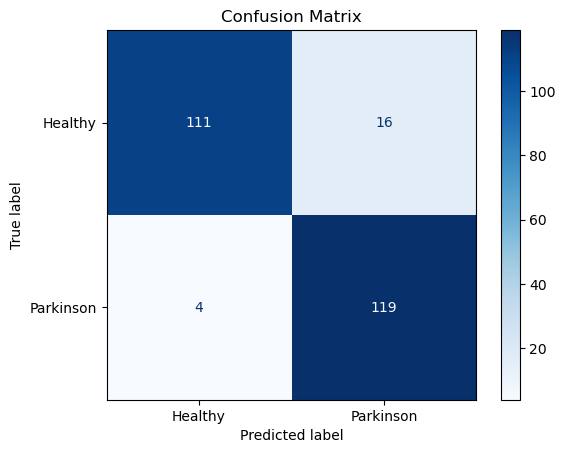

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict all validation set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        audio_input = batch['audio_input'].to(device)
        audio_mask = batch['audio_mask'].to(device)
        text_input = batch['text_input'].to(device)
        text_mask = batch['text_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        outputs = model(audio_input, audio_mask, text_input, text_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Parkinson"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


*Classification Report (Precision, Recall, F1, Accuracy) Table*

              precision    recall  f1-score   support

     Healthy       0.97      0.87      0.92       127
   Parkinson       0.88      0.97      0.92       123

    accuracy                           0.92       250
   macro avg       0.92      0.92      0.92       250
weighted avg       0.92      0.92      0.92       250



,precision,recall,f1-score,support
Healthy,0.97,0.87,0.92,127.00
Parkinson,0.88,0.97,0.92,123.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.92,0.92,0.92,250.00
weighted avg,0.92,0.92,0.92,250.00


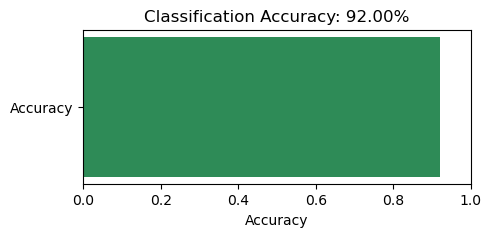

In [10]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report as text
print(classification_report(all_labels, all_preds, target_names=["Healthy", "Parkinson"]))

# As DataFrame (daha görsel)
import pandas as pd
report = classification_report(all_labels, all_preds, target_names=["Healthy", "Parkinson"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.style.background_gradient(axis=1, cmap='Blues').format("{:.2f}"))

# Accuracy bar plot
import matplotlib.pyplot as plt
acc = accuracy_score(all_labels, all_preds)
plt.figure(figsize=(5,2))
plt.barh(['Accuracy'], [acc], color='seagreen')
plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.title(f"Classification Accuracy: {acc:.2%}")
plt.show()

*ROC Curve (for Binary Classification)*

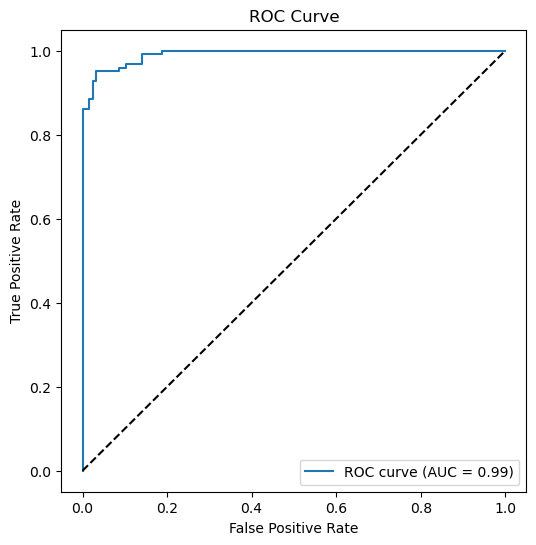

In [11]:
from sklearn.metrics import roc_curve, auc

# Get model probabilities (varsayılan olarak softmax çıkışlı)
all_probs = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        audio_input = batch['audio_input'].to(device)
        audio_mask = batch['audio_mask'].to(device)
        text_input = batch['text_input'].to(device)
        text_mask = batch['text_mask'].to(device)
        outputs = model(audio_input, audio_mask, text_input, text_mask)
        probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()  # Parkinson (pozitif class)
        all_probs.extend(probs)

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

*Wrong Prediction Visualization*

Wrong predictions: 20 / 250 (8.00%)


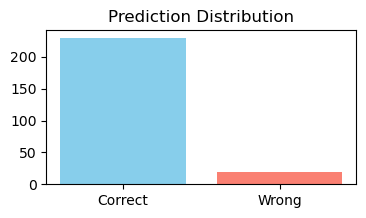

In [12]:
import numpy as np

errors = np.array(all_labels) != np.array(all_preds)
num_errors = errors.sum()
total = len(all_labels)

print(f"Wrong predictions: {num_errors} / {total} ({num_errors/total:.2%})")
plt.figure(figsize=(4,2))
plt.bar(['Correct', 'Wrong'], [total-num_errors, num_errors], color=['skyblue', 'salmon'])
plt.title("Prediction Distribution")
plt.show()
